 ## Исследование причин убытков приложения Procrastinate Pro+
 
#### Приложение Procrastinate Pro+ является убыточным с 3-го квартала 2019 года. Инвестиции в маркетинг не окупаются.

#### Цель исследования: Определить причины убытков приложения Procrastinate Pro+ и разработать рекомендации для отдела маркетинга.
 
#### Исходные данные: данные о пользователях, зарегистрировавшихся в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.

#### Описание данных
Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## 1.Загрузка и предобработка данных.

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

from natsort import natsorted
from natsort import index_natsorted

In [2]:
visits = pd.read_csv('datasets/visits_info_short.csv')  
orders = pd.read_csv('datasets/orders_info_short.csv')
costs = pd.read_csv('datasets/costs_info_short.csv')

In [3]:
display(visits.head(5))
display(orders.head(5))
display(costs.head(5))

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [4]:
visits.info()
print()
orders.info()
print()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column 

- В данных нет пропусков.


Проверим наличие дубликатов в данных

In [5]:
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

0
0
0


- В данных нет дубликатов.


Приведем названия колонок к нижнему регистру

In [6]:
visits.columns=['user_id','region','device','channel','session_start','session_end']
orders.columns=['user_id','event_dt','revenue']
costs.columns=costs.columns.str.lower()

Переведем форматы дат

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

## 2.Функции для расчета и анализа LTV, ROI, удержания и конверсии

#### Функция для расчёта удержания

In [8]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

#### Функция для расчёта конверсии

In [9]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

#### Функция для расчёта LTV и ROI

In [10]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

#### Функция для создания профилей пользователей

In [11]:
def get_profiles(sessions, orders,  ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для визуализации удержания

In [12]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

#### Функция для визуализации конверсии

In [13]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

#### Функция для визуализации LTV и ROI

In [14]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(10, 20))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(5, 1, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(5, 1, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(5, 1, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(5, 1, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(5, 1, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
def filter_data(df, window):
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

## 3. Исследовательский анализ данных

### Создадим пользовательские профили и определим минимальную и максимальную дату привлечения пользователей.

In [16]:
profiles = get_profiles(visits, orders, ad_costs=costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [17]:
print('Минимальная дата привлечения пользователей: ',profiles['dt'].min())
print('Максимальная дата привлечения пользователей: ',profiles['dt'].max())

Минимальная дата привлечения пользователей:  2019-05-01
Максимальная дата привлечения пользователей:  2019-10-27


### Определим из каких стран приходят посетители и какие страны дают больше всего платящих пользователей.

In [18]:
profiles_region=(profiles
                .groupby(['region'])
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id':'количество пользователей'}))
                
profiles_region['количество платящих пользвателей']=(profiles.query('payer == True')
                                        .groupby(['region'])
                                        .agg({'user_id': 'nunique'}))

profiles_region['доля платящих пользователей']=(((profiles_region['количество платящих пользвателей']
                                                /profiles_region['количество пользователей'])*100)
                                                .round(1)
                                                .astype('str')
                                                +'%')

profiles_region = (profiles_region
                   .sort_values(by = 'количество пользователей', ascending = False)
                   .reset_index()
                   .rename(columns={'region':'регион'}))
display(profiles_region)

,регион,количество пользователей,количество платящих пользвателей,доля платящих пользователей
0,United States,100002,6902,6.9%
1,UK,17575,700,4.0%
2,France,17450,663,3.8%
3,Germany,14981,616,4.1%


### Определим с каких устройств заходят пользователи и какова доля платящих пользователей.

In [19]:
profiles_device=(profiles
                .groupby(['device'])
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id':'количество пользователей'}))
                
profiles_device['количество платящих пользвателей']=(profiles.query('payer == True')
                                        .groupby(['device'])
                                        .agg({'user_id': 'nunique'}))

profiles_device['доля платящих пользователей']=(((profiles_device['количество платящих пользвателей']
                                                /profiles_device['количество пользователей'])*100)
                                                .round(1)
                                                .astype('str')
                                                +'%')

profiles_device = (profiles_device
                   .sort_values(by = 'количество пользователей', ascending = False)
                   .reset_index()
                   .rename(columns={'device':'устройство'}))
display(profiles_device)

,устройство,количество пользователей,количество платящих пользвателей,доля платящих пользователей
0,iPhone,54479,3382,6.2%
1,Android,35032,2050,5.9%
2,PC,30455,1537,5.0%
3,Mac,30042,1912,6.4%


### Определим по каким рекламным каналам шло привлечение пользователей и  какие каналы приносят больше всего платящих пользователей.

In [20]:
profiles_channel=(profiles
                .groupby(['channel'])
                .agg({'user_id': 'nunique'})
                .rename(columns={'user_id':'количество пользователей'}))
                
profiles_channel['количество платящих пользвателей']=(profiles.query('payer == True')
                                        .groupby(['channel'])
                                        .agg({'user_id': 'nunique'}))

profiles_channel['доля платящих пользователей']=(((profiles_channel['количество платящих пользвателей']
                                                /profiles_channel['количество пользователей'])*100)
                                                .round(1)
                                                .astype('str')
                                                +'%')

profiles_channel = (profiles_channel
                   .sort_values(by = ('доля платящих пользователей'),
                                ascending = False,
                                key=lambda x: np.argsort(index_natsorted(profiles_channel['доля платящих пользователей'])))
                   .reset_index()
                   .rename(columns={'channel':'канал'}))
display(profiles_channel)

,канал,количество пользователей,количество платящих пользвателей,доля платящих пользователей
0,FaceBoom,29144,3557,12.2%
1,AdNonSense,3880,440,11.3%
2,lambdaMediaAds,2149,225,10.5%
3,TipTop,19561,1878,9.6%
4,RocketSuperAds,4448,352,7.9%
5,WahooNetBanner,8553,453,5.3%
6,YRabbit,4312,165,3.8%
7,MediaTornado,4364,156,3.6%
8,LeapBob,8553,262,3.1%
9,OppleCreativeMedia,8605,233,2.7%


**Вывод:**
1. Предоставлены данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года.
2. Больше всего пользователей в США - 100 тысяч. Также в США и наибольший процент платящих пользователей - 6.9%.
Во Франции, Великобритании и Германии  от 15 до 17.5 тысяч пользователей. Платящих среди них от 3.8 до 4.1%.
3. Чаще пользователи заходят с мобильных устройств. При этом большая доля платящих пользователей среди пользователей iPhone и Mac. 6.2 и 6.4 процента соответственно. На устройствах Android - 5.9%. На персональных компьютерах - 5%.
4. Органических пользователей наибольшее количество, но доля платящих среди них наименьшая: 2.1%
Для остальных компаний доля платящих пользователей от 3.1% до 12.2%.

## 4. Маркетинг

### Определим суммарную сумму расходов на маркетинг и распределение затрат по каналам.

In [21]:
print('Суммарное число инвестиций на привлечение:',costs['costs'].sum().round(5))

Суммарное число инвестиций на привлечение: 105497.3


In [22]:
costs_sum=(costs.groupby('channel')
                .sum()
                .sort_values(by='costs', ascending = False)
                .reset_index())

costs_sum['доля бюджета']=(((costs_sum['costs']/costs['costs'].sum())*100)
                                                .round(2)
                                                .astype('str')
                                                +'%')
display(costs_sum)

,channel,costs,доля бюджета
0,TipTop,54751.30,51.9%
1,FaceBoom,32445.60,30.75%
2,WahooNetBanner,5151.00,4.88%
3,AdNonSense,3911.25,3.71%
4,OppleCreativeMedia,2151.25,2.04%
5,RocketSuperAds,1833.00,1.74%
6,LeapBob,1797.60,1.7%
7,lambdaMediaAds,1557.60,1.48%
8,MediaTornado,954.48,0.9%
9,YRabbit,944.22,0.9%


### Динамика расходов на рекламу по каналам привлечения 

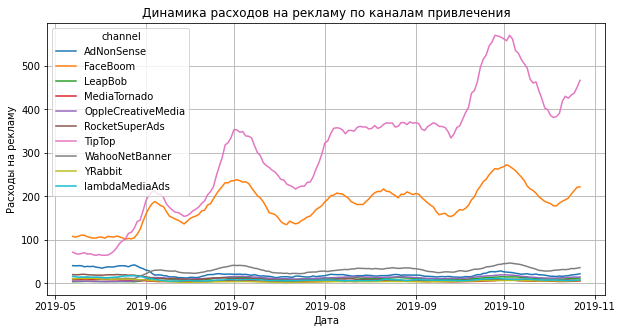

In [23]:
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

costs_change=costs.pivot_table(
    index='dt', columns='channel', values='costs')

for column in costs_change.columns.values:
    costs_change[column]=costs_change[column].rolling(7).mean()
    
costs_change.plot(grid=True, figsize=(10,5))    

plt.ylabel('Расходы на рекламу')
plt.xlabel('Дата')
plt.title('Динамика расходов на рекламу по каналам привлечения')
plt.show()

### САС на одного пользователя для всего проекта и для каждого источника трафика.

In [39]:
#используем ранее полученные данные с общим количеством пользователей каналов
costs_sum=costs_sum.rename(columns={'channel':'канал'})

cac_total=(profiles_channel[['канал','количество пользователей']]
            .merge(costs_sum, on='канал',how='right')
            .rename(columns={'costs':'инвестиции на привлечение'})
            )

cac_total['CAC']=cac_total['инвестиции на привлечение']/cac_total['количество пользователей']

display(cac_total.sort_values(by='доля бюджета',
                              key=lambda x: np.argsort(index_natsorted(cac_total['доля бюджета'])),
                              ascending=False))

,канал,количество пользователей,инвестиции на привлечение,доля бюджета,CAC
0,TipTop,19561,54751.30,51.9%,2.799003
1,FaceBoom,29144,32445.60,30.75%,1.113286
2,WahooNetBanner,8553,5151.00,4.88%,0.602245
3,AdNonSense,3880,3911.25,3.71%,1.008054
4,OppleCreativeMedia,8605,2151.25,2.04%,0.250000
5,RocketSuperAds,4448,1833.00,1.74%,0.412095
7,lambdaMediaAds,2149,1557.60,1.48%,0.724802
6,LeapBob,8553,1797.60,1.7%,0.210172
9,YRabbit,4312,944.22,0.9%,0.218975
8,MediaTornado,4364,954.48,0.9%,0.218717


#### Рассчет САС на одного пользователя для всего проекта 


In [25]:
print('Средний САС на одного пользователя для всего проекта:'
      ,(costs['costs'].sum()/cac_total['количество пользователей'].sum()).round(3))

Средний САС на одного пользователя для всего проекта: 1.127


**Вывод:**
Наибольшие инвестиции были направлены для привлечения через каналы TipTop (51.9% от бюджета) и FaceBoom	(30.75% от бюджета). САС для этих каналов 2.8 и 1.1. На остальные каналы было потрачено от 0.9% до 4.88% и САС составил от 0.21 до 1.0.

## 5.Оценим окупаемость рекламы для привлечения пользователей

### Проанализируемобщую окупаемость рекламы 

In [26]:
profiles['dt'] = pd.to_datetime(profiles['dt']).dt.date
profiles['first_ts'] = pd.to_datetime(profiles['first_ts'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [27]:
observation_date=datetime(2019,11,1).date()
horizon_days=14

##### Исключим из рассмотрения органических пользователей, поскольку для них расчет окупаемости не актуален.


In [28]:
profiles=profiles.query('channel!="organic"')

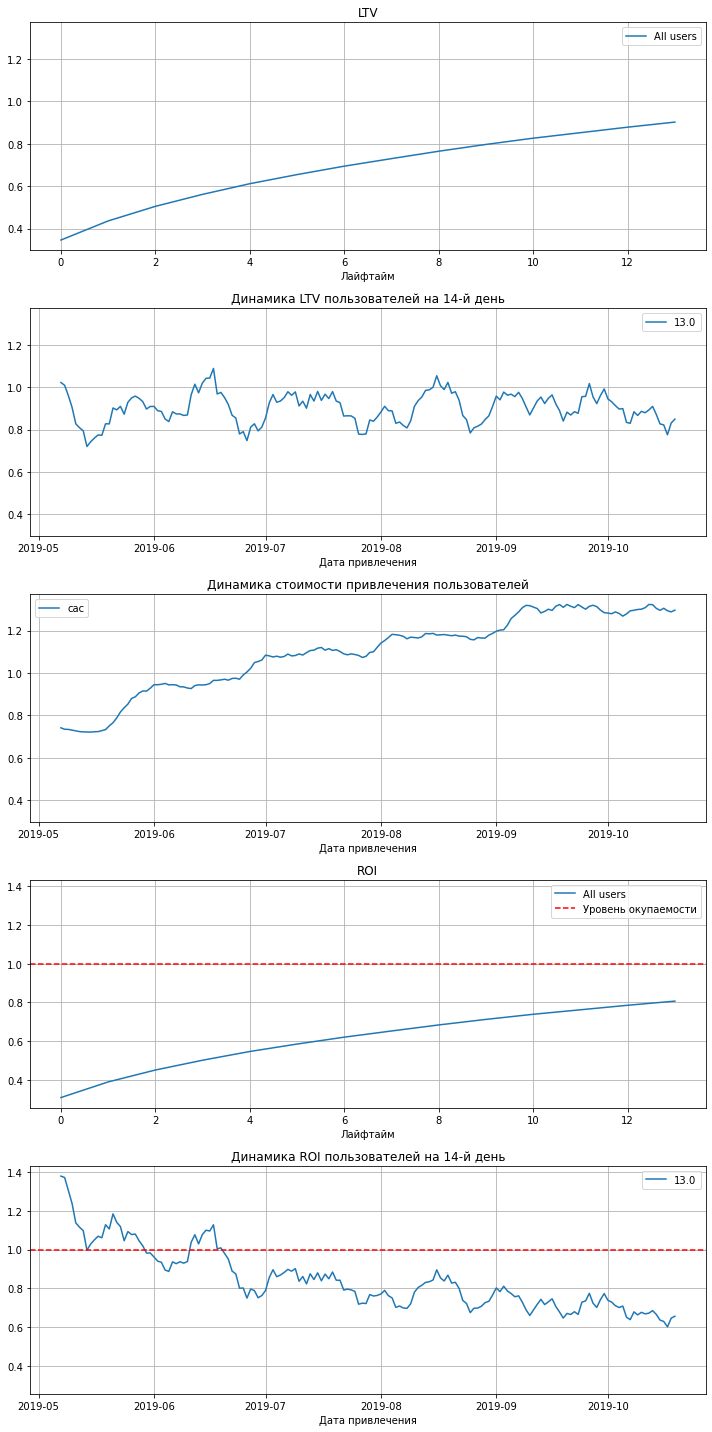

In [29]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

**Вывод:**
- Реклама не окупется. ROI в конце двух недель только приближется к уровню окупаемости.
- САС с мая по октябрь вырос в 3 раза. 
- На LTV влияет сезонный фактор, но показатель стабилен.

### Проанализируем окупаемость рекламы с разбивкой по каналам

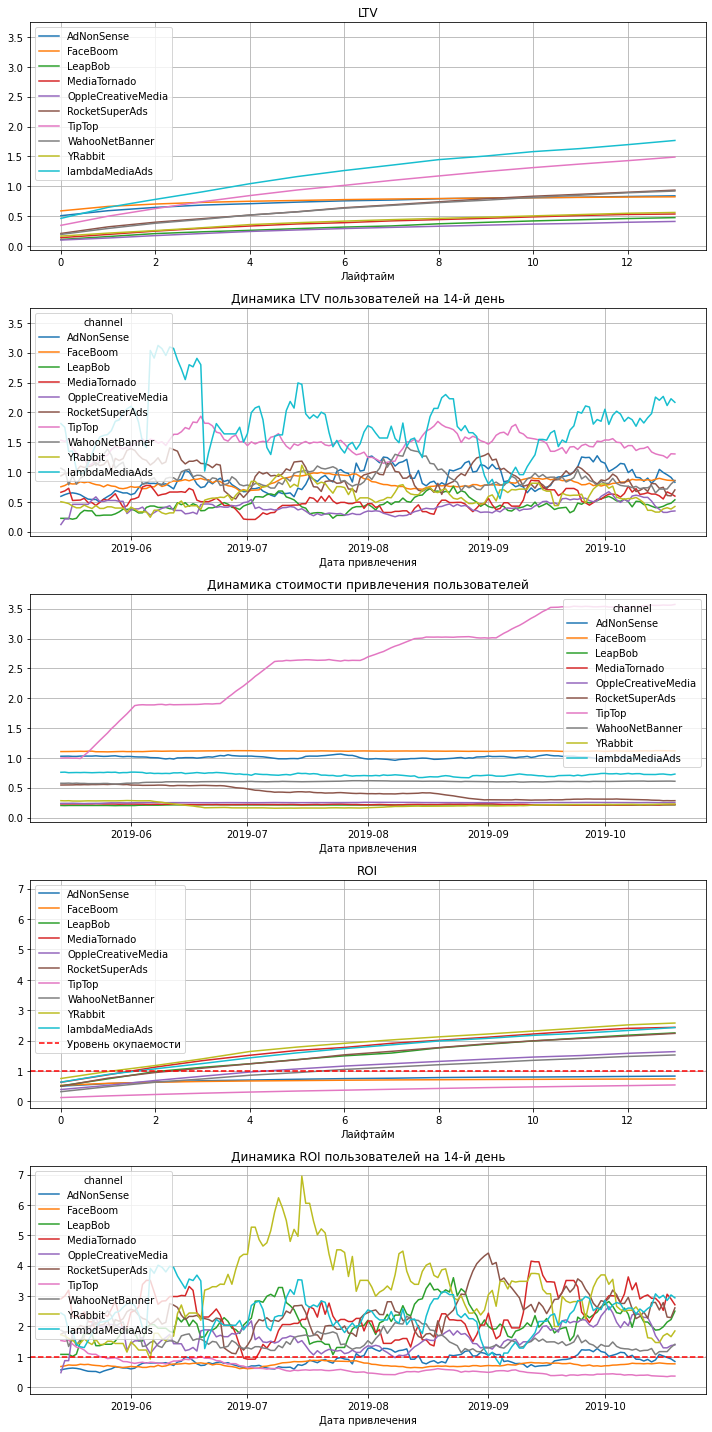

In [30]:
dimensions=['channel']

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days,window=14)

**Вывод:**
- Реклама не окупается для трех каналов: TipTop, FaceBoom, AnNonSence. Данная ситуация стабильна за весь рассматриваемый период.
- Стоимость привлечения через канал TipTop выросла с 1 до 3.7. Для остальных каналов стоимость стабильна. Не окупающиеся FaceBoom, AnNonSence в лидерах.
- LTV подвержен сезонности, но стабилен.
- Явных лидеров по окупаемости нет.

### Проанализируем окупаемость рекламы с разбивкой по устройствам

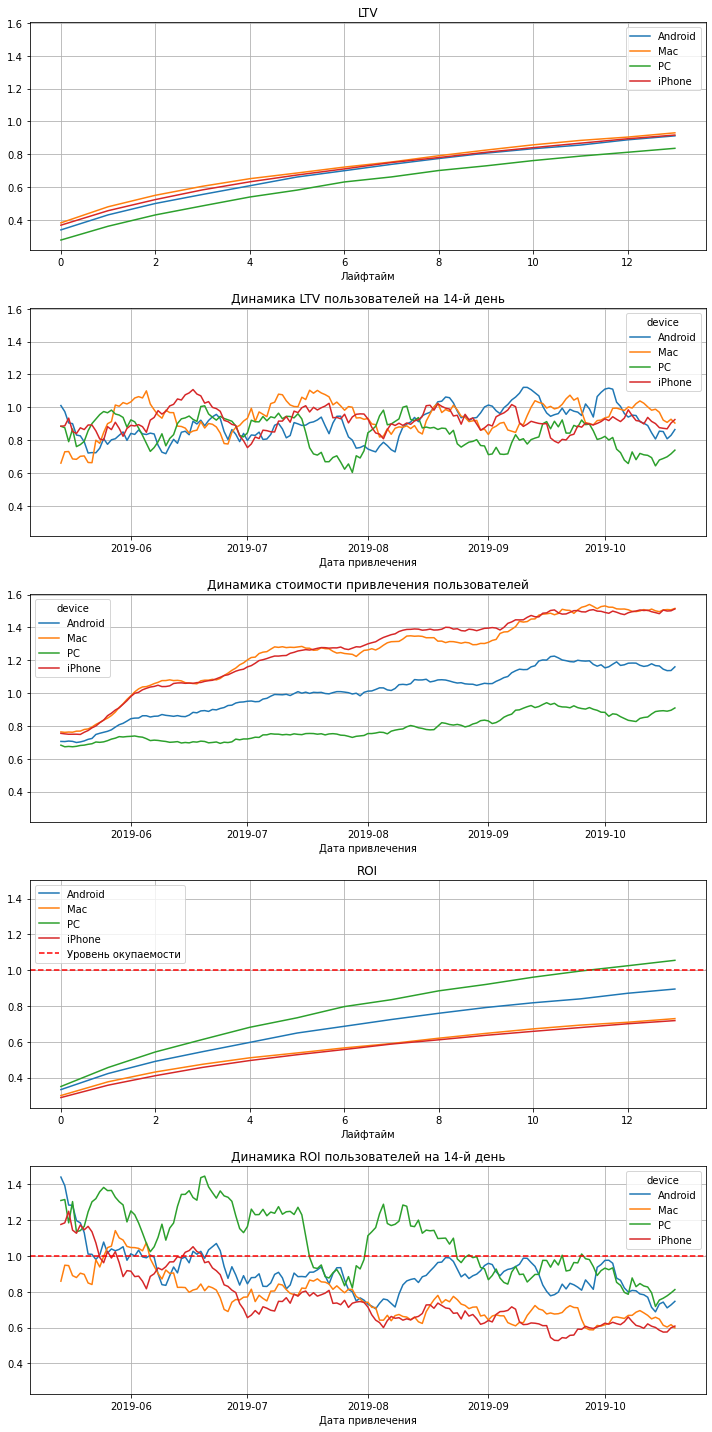

In [31]:
dimensions=['device']
### Проанализируем окупаемость рекламы с разбивкой по регионам
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days,window=14)

**Вывод:** Наилучшими показателями обладают пользователи PC. Несмотря на среднее качество пользователей, низкая стоимость привлечения выводит пользователей на окупаемость. Пользователи остальных устройств ниже уровня окупаемости.

### Проанализируем окупаемость рекламы с разбивкой по регионам

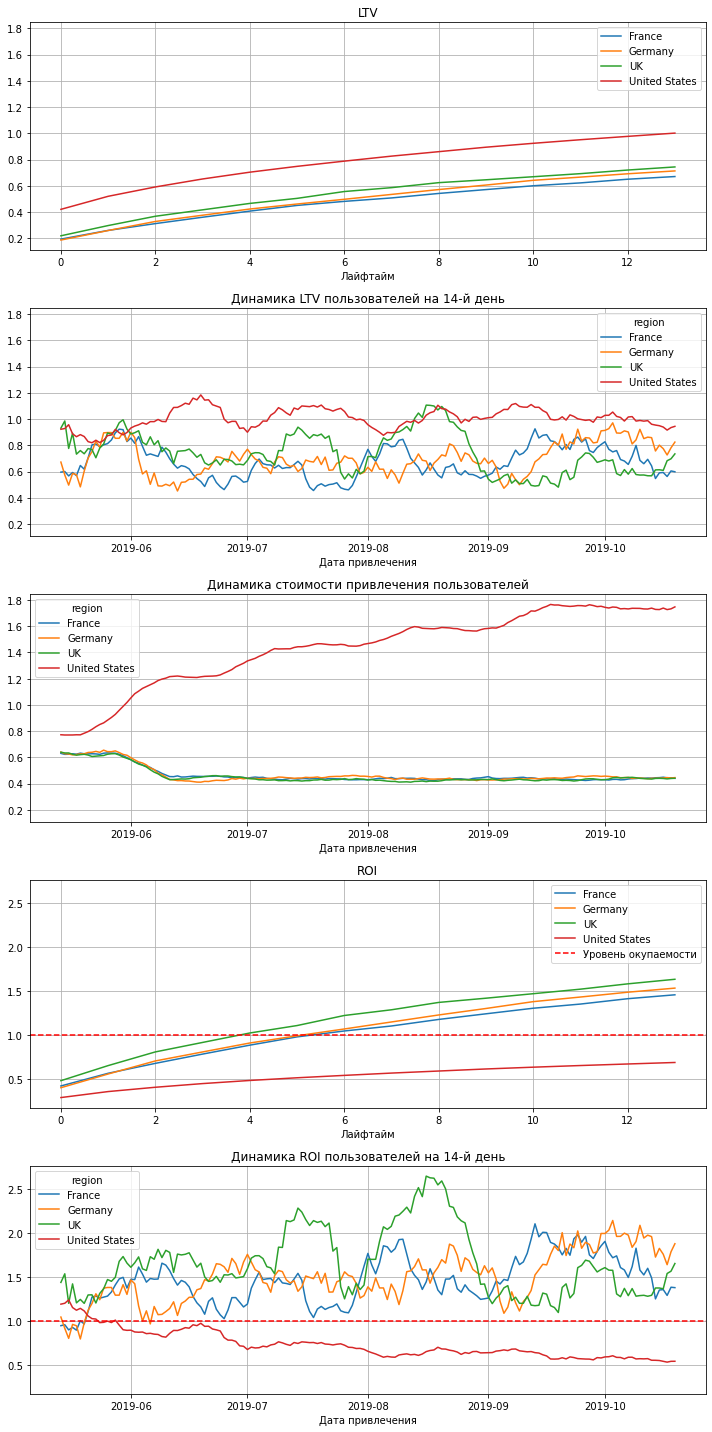

In [32]:
dimensions=['region']

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days,window=14)

**Вывод:**
- Пользователи из США не окупаются.
- Окупаемость пользователей из США была на уровне остальных стран в мае, но в начале июля упала ниже уровня окупаемости.
- Стоимость привлечения пользователей из США была выше чем в других странах в мае и выросла в несколько раз к октябрю.
- Качество пользователей из США заметно выше чем в других странах на всем рассматриваемом периоде.

**Разбивка компаний по странам**

In [33]:
profiles.groupby(['channel','region']).agg({'user_id': 'nunique'})

user_id
channel            region                
AdNonSense         France            1366
                   Germany           1219
                   UK                1295
FaceBoom           United States    29144
LeapBob            France            2988
                   Germany           2519
                   UK                3046
MediaTornado       United States     4364
OppleCreativeMedia France            2991
                   Germany           2562
                   UK                3052
RocketSuperAds     United States     4448
TipTop             United States    19561
WahooNetBanner     France            2971
                   Germany           2579
                   UK                3003
YRabbit            United States     4312
lambdaMediaAds     France             742
                   Germany            649
                   UK                 758

### Изучим конверсию и удержание с разбивкой по устройствам, странам, рекламным каналам.

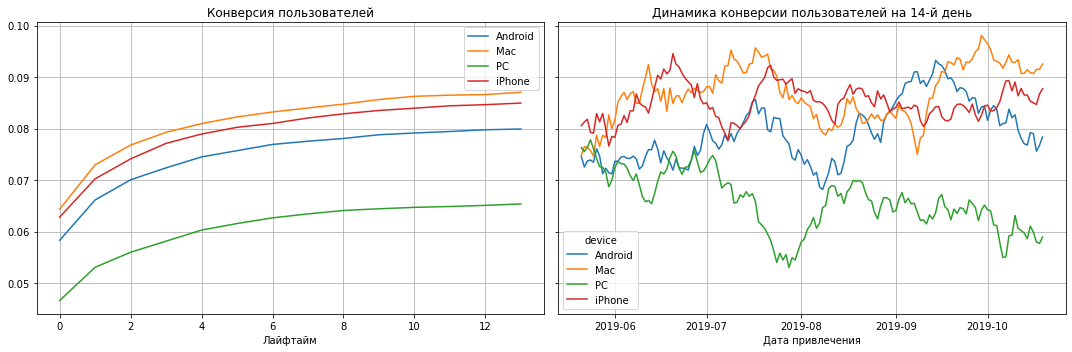

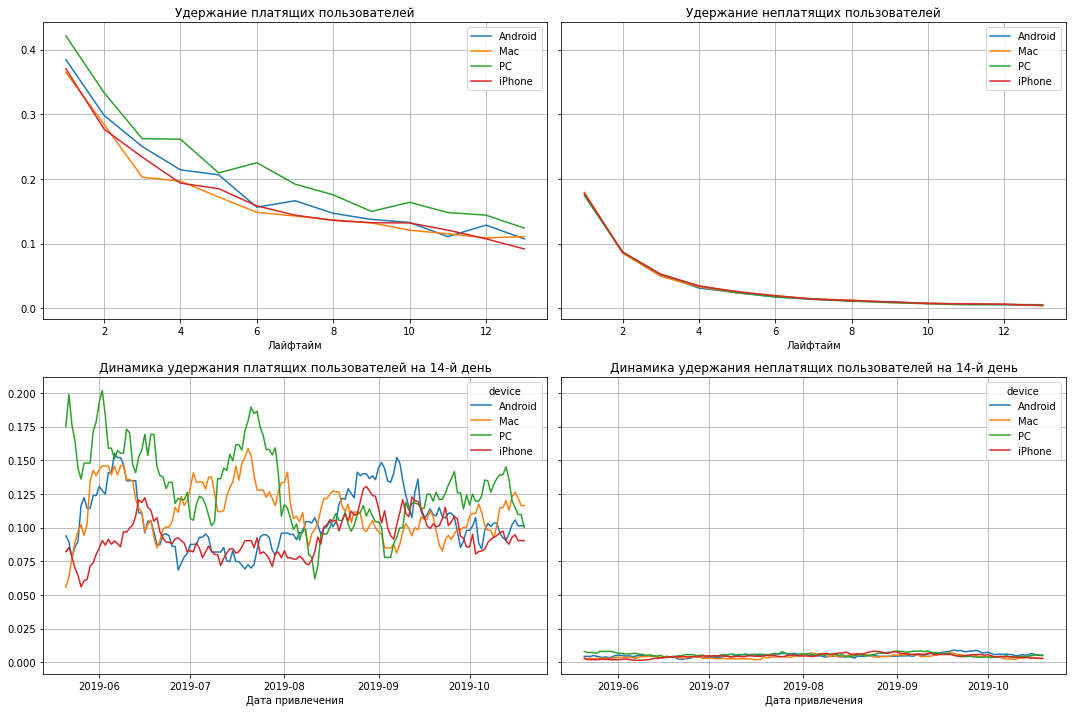

In [34]:
dimensions=['device']
window=21

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,window=window)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=window)

**Вывод:** Графики без анаомалий. Заметен рост конверсии для всех устройств.


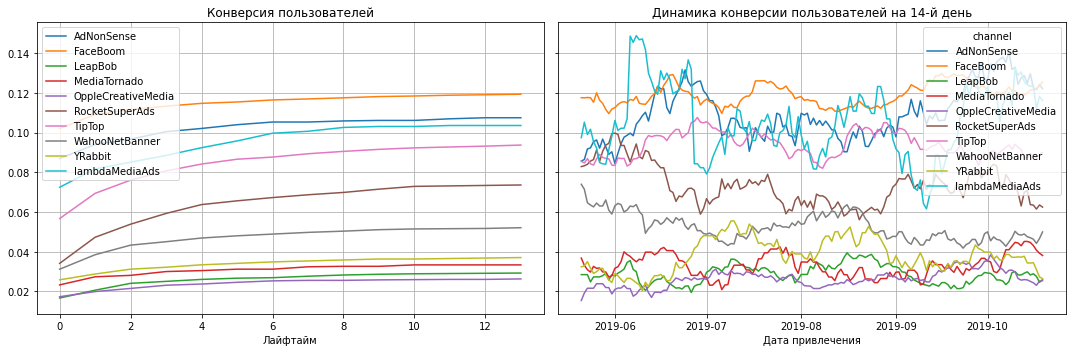

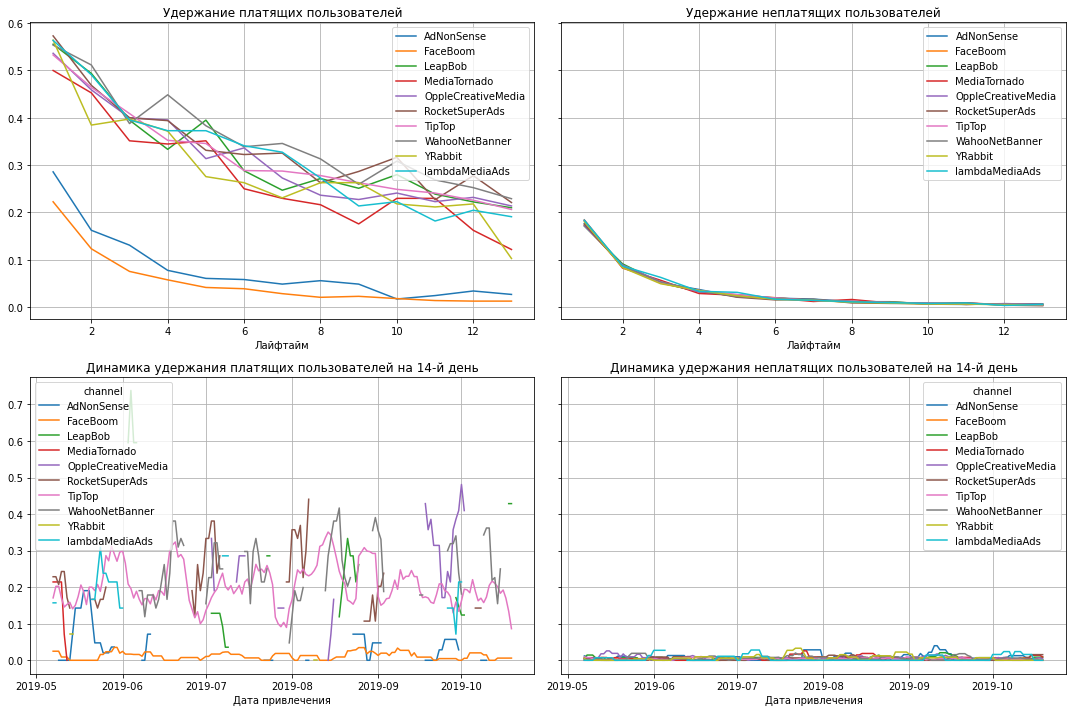

In [35]:
dimensions=['channel']
window=21

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles.query('channel!="organic"'), orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,window=window)

window=7
retention_raw, retention_grouped, retention_history = get_retention(
    profiles.query('channel!="organic"'), visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=window)

**Вывод:** Наилучшая конверсия у каналов AdNonSence и Faceboom. Вместе с этим удержание для этих каналов аномально низкое.

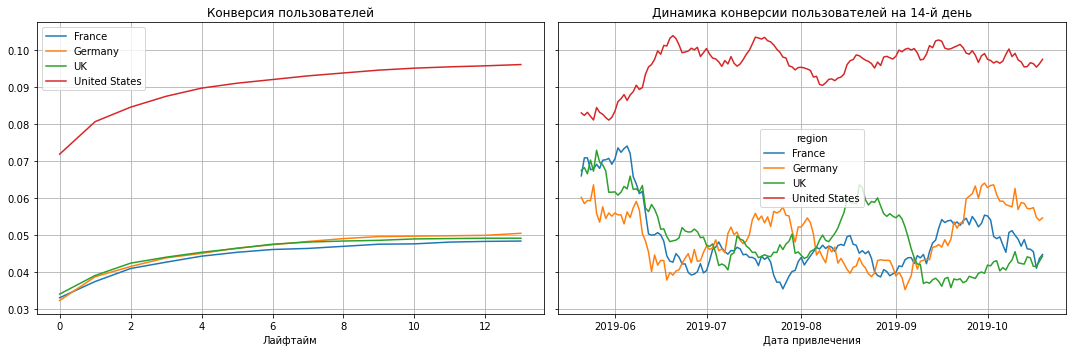

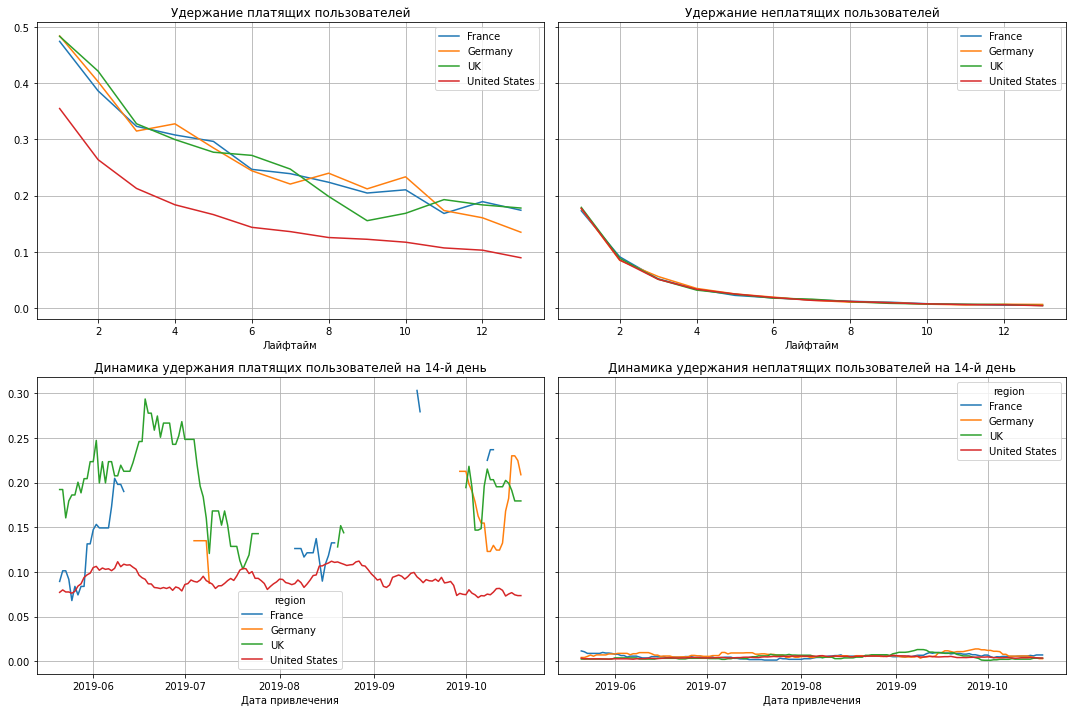

In [36]:
dimensions=['region']
window=21


conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days,window=window)

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days, window=window)

**Вывод:** Низкое удержание клиентов из США. При наибольшей конверсии, которая росла с увеличением инвестиций, удержание стабильно оставалось самым низким.

## Вывод

**Выявленные проблемы:**
- 50% инвестиций приходятся на канал TipTop с хорошими показателями конверсии и удержания. Но высокие инвестиции не приводят к увеличению пользователей, приходящих через канал. Инвестиции избыточны и не дают эффекта - канал убыточен.
- Порядка 30% инвестиций приходится на канал FaceBoom. Убыточный канал с наихудшим удержанием. Имеет хорошую конверсию, количество привлекаемых пользователей растет, но из-за низкого удержания канал стабильно убыточен.
- Убыточный канал AdNonSense. Канал имеет плохое удержание вследствии чего убыточен. Инвестиции в канал: 3.7% бюджета.

**Рекомендации:**
- Снизить инвестиции в канал TipTop до майского уровня. Увеличение инвестиций не дало эффекта.
- Снизить инвестиции или вообще отказаться от канала FaceBoom. Канал был убыточен на всем рассматриваемом периоде.
- Снизить инвестиции или вообще отказаться от канала AdNonSense. Канал периодичестви преодолевает урывень безубыточности, но в основном приносит только потери.
- Рассмотреть для большего инвестирования канал LambdaMediaAds и YRabbit. Компании имеют хорошее качество пользователей, низкую стоимость привлечения, отличную окупаемость, коверсию на уровне выше среднего.